# MinCut with constraints

Many combinatorial optimization problems seek a bit string that maximizes some cost function subject to constraints.  For example, one could ask for a bit string indicating a graph partitioning where the partitions are of equal size.  This is equivalent to searching for bit strings in subspace that has a zero magnetization.  The Hamiltonian that enforces this constraint is
$$\begin{align}
 H = A\left(\sum_{i}\hat{\sigma}_{i}^{z}\right)^{2} = A\sum_{i,j} \hat{\sigma}_{i}^{z}\hat{\sigma}_{j}^{z}.
\end{align}$$
and is analogous to Hamiltonian that appears for equal partition of assets.  The ground state of the Hamiltonian is zero and corresponds to a superposition of bit strings that have magnetization zero.

In [1]:
# first import relevant libraries and initialize a connection to the qvm.
from grove.pyqaoa.qaoa import QAOA
from pyquil.paulis import PauliTerm, PauliSum
import pyquil.quil as pq
from pyquil.gates import X
import pyquil.forest as qvm_module
import numpy as np
cxn = qvm_module.Connection()

We can prepare this operator and the driver Hamiltonian in a similar manner to the maximum cut problem.

In [2]:
n_qubits = 4
cost_operator = []
ref_operator = []
steps = 2
for ii in xrange(n_qubits):
    for jj in xrange(n_qubits):
        cost_operator.append(PauliSum([PauliTerm("Z", ii, 1.0) *
                                  PauliTerm("Z", jj, 1.0)]))
    ref_operator.append(PauliSum([PauliTerm("X", ii, -1.0)]))

inst = QAOA(cxn, n_qubits, steps=steps, cost_ham=cost_operator,
            ref_hamiltonian=ref_operator, store_basis=True, rand_seed=13, vqe_options={'disp': None}, minimizer_kwargs={'method': 'Nelder-Mead', 'options': {'maxfev': 300, 'disp': True}})

We could have looped over the unique indices and given the `PauliTerm` coefficient equal to $2$.  The repeated indices add a constant to the Hamiltonian which does not change the ground state distribution.  The `get_angles()` method of the `QAOA` instance can now be used to identify the optimal angles for the driver and cost rotations by calling the VQE algorithm in `pyQuil`.  

In [4]:
betas, gammas = inst.get_angles()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 126
         Function evaluations: 225


On a real quantum computer we wouldn't recover the entire wave function.  Instead we would check if the ground state was 0.  Since we are working with a QVM instance instead of a real quantum processing unit we can query the wavefunction for debugging purposesses.  To query the final expectation value computed in the VQE algorith we can look at the `result` field in the QAOA object after the `get_angles()` method was run.  The final expectation value is stored in the `fun` object field.

In [5]:
print inst.result.fun

4.14269165638e-08


In [6]:
probs = inst.probabilities(np.hstack((betas, gammas)))
for state, prob in zip(inst.states, probs):
    print state, prob

0000 [  5.68271489e-11+0.j]
0001 [  1.23776398e-09+0.j]
0010 [  1.23776398e-09+0.j]
0011 [ 0.16666666+0.j]
0100 [  1.23776398e-09+0.j]
0101 [ 0.16666666+0.j]
0110 [ 0.16666666+0.j]
0111 [  1.23776398e-09+0.j]
1000 [  1.23776398e-09+0.j]
1001 [ 0.16666666+0.j]
1010 [ 0.16666666+0.j]
1011 [  1.23776398e-09+0.j]
1100 [ 0.16666666+0.j]
1101 [  1.23776398e-09+0.j]
1110 [  1.23776398e-09+0.j]
1111 [  5.68271489e-11+0.j]


As expected the dominant bit strings are the strings with $\hat{J}_{z} = 0$.

## When is this penalty function useful?

Another type of graph parititioning is finding the minimum cut between two equal size clusters.  For example, imagine two clusters that are loosely connected.  Processing the entire graph may be difficult, but breaking up the graph into parts and then performing computation on each disperate set.   Recently, this graph partitioning has been proposed for linear scaling electronic structure calculations.

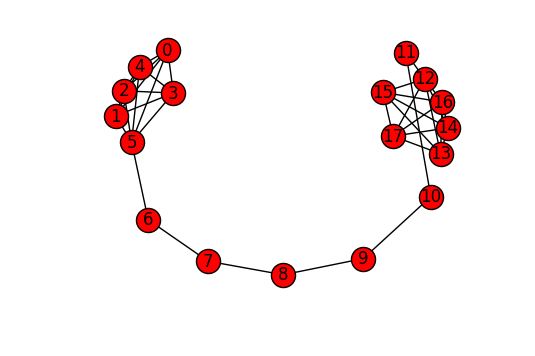

In [16]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
limits=plt.axis('off')

graph = nx.barbell_graph(6, 6, )
nx.draw_networkx(graph, pos=nx.spring_layout(graph), with_labels=True)

If the objective is to identify two large clusters of the graph.  It is easy to see that for a graph like this we want to simply cut the barbell connection between the two fully connected sets of 4 on the end.  The cost function for this is equivalent to a minimum cut.  We want to penalize when the nodes are allocated to different sets
$$\begin{align}
\hat{H} = B\sum_{(\nu, \mu) \in E} (I -\sigma_{\nu}^{Z} \sigma_{\mu}^{Z})/2.
\end{align}
$$
and also penalize when we don't have an even partition with the penalty operator given above
$$\begin{align}
 H = A\left(\sum_{i}\hat{\sigma}_{i}^{z}\right)^{2} = A\sum_{i,j} \hat{\sigma}_{i}^{z}\hat{\sigma}_{j}^{z}.
\end{align}$$
We need to ensure that the grouping term ($B$) doesn't dominate energy scale of the problem.  In order to avoid this situation the ratio of A/B can be selected to balance the effects of violating a constraint in Hamiltonian A and gaining energy from B. We can now construct the cost and driver Hamiltonians very naturally from iterating over the edges of the graph.

In [8]:
cost_operators = []
driver_operators = []
B = 1
max_degree = max(graph.degree(), key=lambda x: graph.degree()[x])
# bounds from arXiv: 1302:5843v3
A_B_ratio = min(2*max_degree, len(graph.nodes()))/8.0
A = A_B_ratio
for node in graph.nodes():
    for node_j in graph.nodes():
        cost_operators.append(PauliSum([PauliTerm("Z", node, A)*PauliTerm("Z", node_j, 1.0)]))
    driver_operators.append(PauliSum([PauliTerm("X", node, -1)]))
    
for i, j in graph.edges():
    cost_operators.append(PauliTerm("Z", i, -B*0.5)*PauliTerm("Z", j, 1.0) + PauliTerm("I", 0, B*0.5))
    
# set number of qubits
n_qubits = len(graph.nodes())

We can now instantiate the `QAOA`object and run the VQE loop to find the angles.

In [9]:
from scipy.optimize import minimize
n_qubits= len(graph.nodes())
def print_fun(x):
    print x
    
qaoa_inst = QAOA(cxn, n_qubits, steps=1, cost_ham=cost_operators, ref_hamiltonian=driver_operators, store_basis=True,
                 minimizer=minimize, minimizer_kwargs={'method': 'Nelder-Mead',
                                                       'options': {'ftol': 1.0e-2, 'xtol': 1.0e-2, 'disp': True, 'maxfev': 10000}},
                 vqe_options={'disp': print_fun}, rand_seed=42)

Including the penalty term in the cost function Hamiltonian drastically increases the size of the Quil Program needed for execution.  There are $N(N - 1)/2$ terms more which are all Hamiltonians with two Pauli operators in their string requiring entanglement.  Since the sum runs over all the qubits we potentially must entangle an arbitrary number of qubits across the lattice.  Furthermore, It seems unlikely that the most probably bit string will be determined by low step size.  Just as a demonstration let's run p=1 for the penalty Hamiltonian.

In [10]:
betas, gammas = qaoa_inst.get_angles()

	Parameters: [ 1.23548511  6.27218987] 
	E => 15.1008716657
	Parameters: [ 1.23548511  6.27218987] 
	E => 15.1008716657
	Parameters: [ 1.21342288  6.19752094] 
	E => 14.4297504557
	Parameters: [ 1.2722555   6.19752094] 
	E => 11.9691379411
	Parameters: [ 1.23916215  6.23485541] 
	E => 11.7019385153
	Parameters: [ 1.29799477  6.23485541] 
	E => 11.1633744119
	Parameters: [ 1.29799477  6.23485541] 
	E => 11.1633744119
	Parameters: [ 1.37429333  6.20685456] 
	E => 10.4955652723
	Parameters: [ 1.37429333  6.20685456] 
	E => 10.4955652723
	Parameters: [ 1.37429333  6.20685456] 
	E => 10.4955652723
	Parameters: [ 1.34010836  6.20860461] 
	E => 10.4800797431
	Parameters: [ 1.36838996  6.19912516] 
	E => 10.4328935064
	Parameters: [ 1.36838996  6.19912516] 
	E => 10.4328935064
	Parameters: [ 1.36838996  6.19912516] 
	E => 10.4328935064
	Parameters: [ 1.35907146  6.20073165] 
	E => 10.4281778627
Optimization terminated successfully.
         Current function value: 10.428178
         Iterations

Clearly, the objective is siginficantly above the true ground state that we know to be 1.0.  We can then ask for the most frequent bitstring from sampling to gauge if the VQE loop was able to find angles that produced a distribution around the desired solution.

In [11]:
most_freq_string, sampling_results = qaoa_inst.get_string(betas, gammas, samples=100)

In [12]:
most_freq_string

(0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0)

As expected from the value of the cost function at the end of the optimization the distribution we are sampling from does not represent a distribution that is dominated by the ground state configuration.  We would expect a degenerate ground state peaked around the strings $(0,0,0,0,0,0,1,1,1,1,1,1)$ and $(1,1,1,1,1,1,0,0,0,0,0,0)$.

In [13]:
probs = qaoa_inst.probabilities(np.hstack((betas, gammas)))

In [14]:
# plotting strings!
def plot(inst, probs):
    probs = probs.real
    states = inst.states
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel("state",fontsize=20)
    ax.set_ylabel("Probability",fontsize=20)
    ax.set_xlim([0, 2**inst.n_qubits])
    rec = ax.bar(range(2**n_qubits), probs, )
    num_states = [0, int("".join(str(x) for x in [0] * (inst.n_qubits/2) + [1] * (inst.n_qubits/2) ), 2), 
              int("".join(str(x) for x in [1] * (inst.n_qubits/2) + [0] * (inst.n_qubits/2)), 2), 2**inst.n_qubits - 1 ]
    ax.set_xticks(num_states)
    ax.set_xticklabels(map(lambda x: inst.states[x], num_states), rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

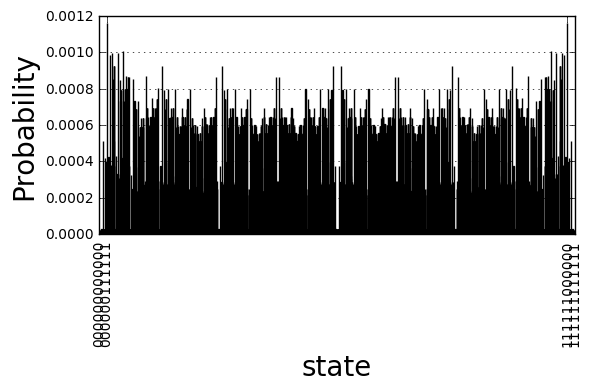

In [15]:
plot(qaoa_inst, probs)

Clearly, It is quite difficult to use VQE to determine the optimal parameters for the penalized cost Hamiltonian. We easily converge to local minimum. Furthermore the Quil program now requires entanglement between qubits that could be seperated by a great distance on some physical device.  This requires many swap steps to perform entangling gates.

# Constrained driver Hamiltonian
We can remove the constraint term from the problem Hamiltonian by selecting a driver that commutes with the penalty term and the cost Hamiltonian.  Therefore, the constraint will be a consant of motion and if we start the QAOA algorithm with a reference that is in the correct subspace satisfying the constraint we will stay in the space.  This results in siginficantly fewer Hamiltonian terms and avoids the difficulty of identifying the correct penalty strengths based on the cost degree of a graph.  

In the following we will replace our driver Hamiltonian with
$$
\begin{align}
\hat{H}_{\mathrm{Driver}} = -\sum_{i = 1}^{n} \sigma_{n}^{X}\sigma_{n+1}^{X} + \sigma_{n}^{Y}\sigma_{n+1}^{Y}
\end{align}
$$
where $n$ is the number of qubits.  Another feature of this driver is that it is the natural Hamiltonian of common superconducting qubits. 

In [17]:
set_length = len(graph.nodes())
driver_operators = []
cost_operators = []
for node in xrange(set_length):
    one_driver_term = PauliTerm("X", node, -1.0) * PauliTerm("X", (node + 1) % set_length, 1.0) + PauliTerm("Y", node, -1.0) * PauliTerm("Y", (node + 1) % set_length, 1.0)
    driver_operators.append(one_driver_term)
    
for i, j in graph.edges():
    cost_operators.append(PauliTerm("Z", i, -0.5)*PauliTerm("Z", j, 1.0) + PauliTerm("I", 0, 0.5))

We will also replace our initial state to correspond with a state in the correct subspace of the Hamiltonian.  The penalty function from before indicated that we need to start somewhere in the zero magnetization subspace.  This is achieved by simply flipping $n/2$ of the bits.

In [18]:
start_prog = pq.Program()
for node in xrange(set_length/2):
    start_prog.inst(X(node))

In [19]:
n_qubits= len(graph.nodes())
qaoa_inst_constraint = QAOA(cxn, n_qubits, steps=1, cost_ham=cost_operators, ref_hamiltonian=driver_operators, store_basis=True,
                 driver_ref=start_prog,
                 minimizer=minimize, minimizer_kwargs={'method': 'Nelder-Mead',
                                                       'options': {'ftol': 1.0e-1, 'xtol': 1.0e-1, 'disp': True, 'maxfev': 10000}},
                 vqe_options={'disp': print_fun}, rand_seed=42)

We now want to start our QAOA run in the correct subspace.  Since our constraint corresponded to equal size subgraphs we want to perform an `X` operation on half of the qubits.

In [22]:
betas, gammas = qaoa_inst_constraint.get_angles()

	Parameters: [ 1.23548511  5.97351416] 
	E => 5.69739120382
	Parameters: [ 1.35315036  5.5255006 ] 
	E => 3.13718391107
	Parameters: [ 1.41198298  5.89884523] 
	E => 2.17080732643
	Parameters: [ 1.52964823  5.45083167] 
	E => 1.08108865348
	Parameters: [ 1.58848086  5.82417631] 
	E => 1.01500538468
	Parameters: [ 1.58848086  5.82417631] 
	E => 1.01500538468
	Parameters: [ 1.58848086  5.82417631] 
	E => 1.01500538468
	Parameters: [ 1.56090306  5.57450208] 
	E => 1.00469746677
	Parameters: [ 1.56090306  5.57450208] 
	E => 1.00469746677
	Parameters: [ 1.57285344  5.7623411 ] 
	E => 1.00020312117
	Parameters: [ 1.57285344  5.7623411 ] 
	E => 1.00020312117
	Parameters: [ 1.57285344  5.7623411 ] 
	E => 1.00020312117
	Parameters: [ 1.57285344  5.7623411 ] 
	E => 1.00020312117
	Parameters: [ 1.57285344  5.7623411 ] 
	E => 1.00020312117
	Parameters: [ 1.57196291  5.66218703] 
	E => 1.00006532355
	Parameters: [ 1.57056247  5.65884188] 
	E => 1.00000262502
	Parameters: [ 1.57056247  5.65884188] 


The reduction of complexity in the Hamiltonian also allowed us to easily determine angles that result in a distribution that is peaked around the ground state.  The following two sells indicate that the distribution is actually a delta function around one of the solutions!

In [23]:
probs = qaoa_inst_constraint.probabilities(np.hstack((betas, gammas)))

KeyboardInterrupt: 

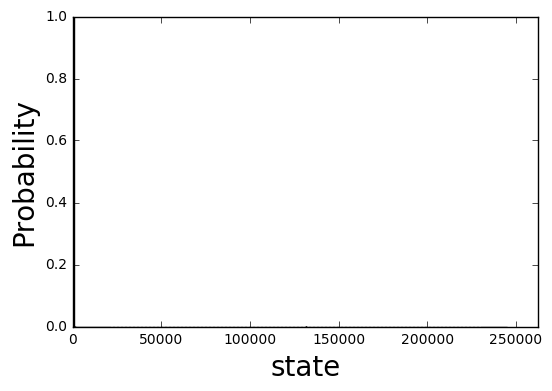

In [24]:
plot(qaoa_inst_constraint, probs)

Now we can sample and look at the solution and get the correct bit string with practically 100% probability.

In [25]:
print betas, gammas
most_freq_string, sampling_results = qaoa_inst_constraint.get_string(betas, gammas, samples=100)

[ 1.57056247] [ 5.65884188]


In [ ]:
print most_freq_string

We can visualize our graph parititioning by assigning different colors to the $|0\rangle$ or $|1\rangle$.

In [ ]:
draw_colors = [ 'r' if x==1 else 'b' for x in most_freq_string]

In [ ]:
nx.draw_networkx(graph, pos=nx.spring_layout(graph), with_labels=True, node_color=draw_colors)

As expected we get the correct minimum cut of the graph.